In [1]:
# PDF印刷用
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

try:
    from google.colab import files
except:
    pass

pdf_ind = 2
pdf_base = 'pdf-01-'

def create_pdf():
    global pdf_ind, pdf_base
    fn = f'{pdf_base}{pdf_ind:02d}.pdf'
    print(fn)
    plt.rcParams['figure.subplot.bottom'] = 0.15
    plt.rcParams['figure.subplot.left'] = 0.15
    plt.savefig(fn)
    try:
        files.download(fn)
    except:
        pass
    pdf_ind = pdf_ind + 1

### 11.5  過学習対策

### ライブラリ・環境設定

#### ライブラリ導入

In [2]:
# 必要ライブラリ追加導入
!pip install japanize-matplotlib -qq
!pip install torchviz -qq
!pip install torchinfo -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 103.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


#### ライブラリインポート

In [3]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchinfo import summary
from tqdm.notebook import tqdm

#### 環境設定

In [4]:
np.set_printoptions(formatter={'float': '{:0.3f}'.format})
pd.options.display.float_format = '{:.3f}'.format
warnings.filterwarnings('ignore')

#### GPU存在チェック

In [5]:
# GPU存在チェック

# GPUが利用可能かどうかのチェック
device = torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")

# 利用可能な場合は"cuda:0"が出力される
print(device)

cuda:0


### データ準備

#### データローダー構築

In [6]:
# データローダー構築
def get_data_loaders(batch_size=100, data_dir="./data"):
    """MNISTの訓練・テストデータをDataLoaderで返す"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_set = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
    test_set  = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, test_loader

batch_size = 100
train_loader, test_loader = get_data_loaders(batch_size)


100%|██████████| 9.91M/9.91M [00:01<00:00, 4.96MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.7MB/s]


### モデル構築

#### モデル定義(オリジナル)



In [12]:
class Net(nn.Module):
    """全結合1層のシンプルなNN（MNIST想定: 28*28 -> 100 -> 10）"""
    def __init__(self, n_input=28*28, n_hidden=100, n_output=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_output)
        )

    def forward(self, x):
        # (B, 1, 28, 28) -> (B, 784)
        x = torch.flatten(x, 1)
        return self.net(x)

#### モデル定義(dropout付き)

In [7]:
# モデル定義(dropout付き)

class Net2(nn.Module):
    """ドロップアウトを導入したモデル"""
    def __init__(self, n_input=28*28, n_hidden=100, n_output=10, dropout_p=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_p),  # ドロップアウト層を追加
            nn.Linear(n_hidden, n_output)
        )

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.net(x)

#### モデル定義(batch normalization付き)

In [8]:
# モデル定義(batch normalization付き)
class Net3(nn.Module):
    """バッチ正規化を導入したモデル"""
    def __init__(self, n_input=28*28, n_hidden=100, n_output=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.BatchNorm1d(n_hidden),  # バッチノーマライゼーションを追加
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_output)
        )

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.net(x)

#### 訓練用関数

In [9]:
# 学習用関数

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 勾配初期化
        optimizer.zero_grad()
        # 予測計算
        outputs = model(inputs)
        # 損失計算
        loss = criterion(outputs, labels)
        # 勾配(微分)計算
        loss.backward()
        # パラメータ更新
        optimizer.step()

        with torch.no_grad():
            preds = outputs.argmax(1)
            running_loss += loss.item() * labels.size(0)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

#### 検証用関数

In [10]:
# 検証用関数

@torch.no_grad()
def validate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        preds = outputs.argmax(1)

        running_loss += loss.item() * labels.size(0)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

#### 学習関数

In [13]:
def fit(*, net_class=Net, n_hidden=100, num_epochs=20, lr=0.01,
        batch_size=100, optimizer_class=optim.SGD,
        seed=42, data_dir="./data"):
    """
    引数（すべてキーワード専用）:
        net_class       : モデルクラス（例: Net, CustomCNNなど）
        n_hidden        : 隠れ層ノード数（Net使用時のみ）
        num_epochs      : 繰り返し数
        lr              : 学習率
        batch_size      : バッチサイズ
        optimizer_class : 最適化関数クラス (例: optim.SGD, optim.Adam)

    戻り値:
        model, history(np.ndarray: [epoch, train_loss, train_acc, val_loss, val_acc])
    """
    torch.manual_seed(seed)
    np.random.seed(seed)

    # DataLoader作成（バッチサイズ指定）
    train_loader, test_loader = get_data_loaders(batch_size=batch_size,
                                                 data_dir=data_dir)

    # モデル構築（引数対応）
    try:
        model = net_class(n_hidden=n_hidden).to(device)
    except TypeError:
        model = net_class().to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), lr=lr)

    history = []
    for epoch in tqdm(range(1, num_epochs + 1), desc="Training"):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion,
                                          optimizer)
        va_loss, va_acc = validate(model, test_loader, criterion)

        print(
            f"Epoch [{epoch}/{num_epochs}] "
            f"train_loss: {tr_loss:.5f}, train_acc: {tr_acc:.5f}, "
            f"val_loss: {va_loss:.5f}, val_acc: {va_acc:.5f}"
        )
        history.append([epoch, tr_loss, tr_acc, va_loss, va_acc])

    return model, np.array(history, dtype=float)

#### 学習

In [15]:
# オリジナルモデル
model1, history1 = fit(net_class=Net, num_epochs=20, lr=0.01)

# Dropout付きモデル
model2, history2 = fit(net_class=Net2, num_epochs=20, lr=0.01)

# BatchNorm付きモデル
model3, history3 = fit(net_class=Net3, num_epochs=20, lr=0.01)

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20] train_loss: 0.70944, train_acc: 0.82948, val_loss: 0.36484, val_acc: 0.90030
Epoch [2/20] train_loss: 0.34260, train_acc: 0.90292, val_loss: 0.30016, val_acc: 0.91420
Epoch [3/20] train_loss: 0.29471, train_acc: 0.91510, val_loss: 0.26729, val_acc: 0.92500
Epoch [4/20] train_loss: 0.26505, train_acc: 0.92348, val_loss: 0.24612, val_acc: 0.93000
Epoch [5/20] train_loss: 0.24184, train_acc: 0.93078, val_loss: 0.22569, val_acc: 0.93780
Epoch [6/20] train_loss: 0.22313, train_acc: 0.93635, val_loss: 0.21003, val_acc: 0.94170
Epoch [7/20] train_loss: 0.20713, train_acc: 0.94155, val_loss: 0.19760, val_acc: 0.94460
Epoch [8/20] train_loss: 0.19323, train_acc: 0.94583, val_loss: 0.18607, val_acc: 0.94630
Epoch [9/20] train_loss: 0.18111, train_acc: 0.94885, val_loss: 0.17638, val_acc: 0.95000
Epoch [10/20] train_loss: 0.17037, train_acc: 0.95200, val_loss: 0.16643, val_acc: 0.95260
Epoch [11/20] train_loss: 0.16080, train_acc: 0.95498, val_loss: 0.15776, val_acc: 0.95460
Epoch [1

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20] train_loss: 0.88731, train_acc: 0.74558, val_loss: 0.39872, val_acc: 0.89540
Epoch [2/20] train_loss: 0.48066, train_acc: 0.86027, val_loss: 0.31476, val_acc: 0.91390
Epoch [3/20] train_loss: 0.40845, train_acc: 0.88220, val_loss: 0.27398, val_acc: 0.92300
Epoch [4/20] train_loss: 0.36549, train_acc: 0.89480, val_loss: 0.24781, val_acc: 0.92960
Epoch [5/20] train_loss: 0.33169, train_acc: 0.90515, val_loss: 0.22702, val_acc: 0.93480
Epoch [6/20] train_loss: 0.31158, train_acc: 0.91055, val_loss: 0.21169, val_acc: 0.93910
Epoch [7/20] train_loss: 0.29484, train_acc: 0.91530, val_loss: 0.19911, val_acc: 0.94290
Epoch [8/20] train_loss: 0.28095, train_acc: 0.91940, val_loss: 0.18960, val_acc: 0.94350
Epoch [9/20] train_loss: 0.27010, train_acc: 0.92285, val_loss: 0.17993, val_acc: 0.94670
Epoch [10/20] train_loss: 0.25845, train_acc: 0.92635, val_loss: 0.17234, val_acc: 0.94940
Epoch [11/20] train_loss: 0.25124, train_acc: 0.92863, val_loss: 0.16570, val_acc: 0.95090
Epoch [1

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20] train_loss: 0.68307, train_acc: 0.85135, val_loss: 0.36822, val_acc: 0.91330
Epoch [2/20] train_loss: 0.34506, train_acc: 0.91368, val_loss: 0.27969, val_acc: 0.92610
Epoch [3/20] train_loss: 0.27979, train_acc: 0.92710, val_loss: 0.23837, val_acc: 0.93720
Epoch [4/20] train_loss: 0.24543, train_acc: 0.93470, val_loss: 0.21735, val_acc: 0.94130
Epoch [5/20] train_loss: 0.22063, train_acc: 0.94147, val_loss: 0.19516, val_acc: 0.94630
Epoch [6/20] train_loss: 0.20212, train_acc: 0.94590, val_loss: 0.18191, val_acc: 0.95030
Epoch [7/20] train_loss: 0.18698, train_acc: 0.95103, val_loss: 0.17187, val_acc: 0.95320
Epoch [8/20] train_loss: 0.17521, train_acc: 0.95425, val_loss: 0.16203, val_acc: 0.95530
Epoch [9/20] train_loss: 0.16342, train_acc: 0.95697, val_loss: 0.15624, val_acc: 0.95800
Epoch [10/20] train_loss: 0.15455, train_acc: 0.96047, val_loss: 0.14630, val_acc: 0.96150
Epoch [11/20] train_loss: 0.14561, train_acc: 0.96292, val_loss: 0.14269, val_acc: 0.96220
Epoch [1

### 結果確認

In [16]:
import matplotlib.pyplot as plt

def plot_learning_curves_multi(histories, labels=None, title_suffix=""):
    """
    複数のhistoryを黒と青のみで重ねて描画
    実線: 訓練データ, 破線: テストデータ
    """
    plt.figure(figsize=(10, 4), tight_layout=True)

    # --- 線スタイルの組み合わせ（黒と青のみ）---
    colors = ['b', 'k', 'b']        # 4本まで対応
    linestyles = ['-', '--', ':']  # パターンで区別

    # --- 損失曲線 ---
    plt.subplot(1, 2, 1)
    for i, history in enumerate(histories):
        epochs = history[:, 0]
        train_loss = history[:, 1]
        val_loss = history[:, 3]
        color = colors[i % len(colors)]
        ls_val = linestyles[(i + 0) % len(linestyles)]  # テストは異なる線種

        label_val   = f"{labels[i]}(テスト)" if labels else f"model{i+1}(テスト)"

        plt.plot(epochs, val_loss,   color=color, linestyle=ls_val,   label=label_val)

    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.title(f'学習曲線（損失）{title_suffix}')
    plt.legend(fontsize=8)
    plt.grid(True)

    # --- 精度曲線 ---
    plt.subplot(1, 2, 2)
    for i, history in enumerate(histories):
        epochs = history[:, 0]
        train_acc = history[:, 2]
        val_acc   = history[:, 4]
        color = colors[i % len(colors)]
        ls_val = linestyles[(i + 0) % len(linestyles)]

        label_val   = f"{labels[i]}(テスト)" if labels else f"model{i+1}(テスト)"

        plt.plot(epochs, val_acc,   color=color, linestyle=ls_val,   label=label_val)

    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.xticks(np.arange(0,21,2))
    plt.title(f'学習曲線（精度）{title_suffix}')
    plt.legend(fontsize=8)
    plt.grid(True)
    create_pdf()
    plt.show()


pdf-01-02.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

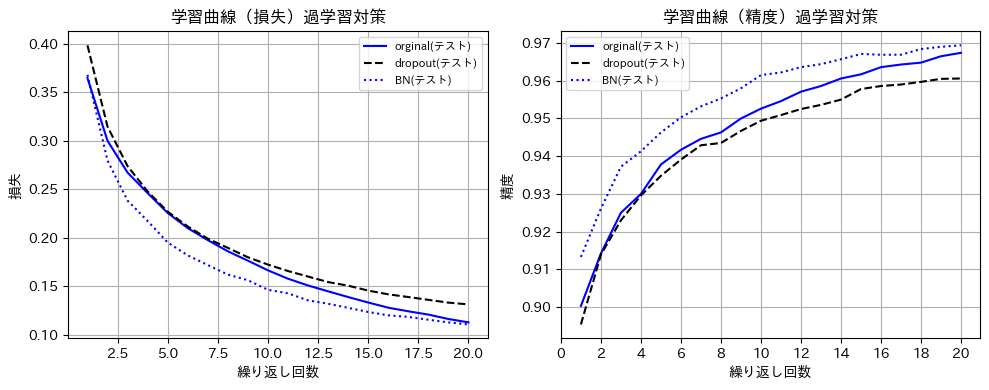

In [17]:
# 3つのhistoryを比較して描画
histories = [history1, history2, history3]
plot_learning_curves_multi(
    histories,
    labels=["orginal", "dropout", "BN"],
    title_suffix="過学習対策"
)


### 結果確認

#### 学習曲線の描画

In [ ]:
def plot_learning_curves(history, title_suffix=""):
    """損失と精度の学習曲線を並べて描画"""
    epochs = history[:, 0]
    train_loss = history[:, 1]
    train_acc  = history[:, 2]
    val_loss   = history[:, 3]
    val_acc    = history[:, 4]

    plt.figure(figsize=(8, 4), tight_layout=True)

    # --- 損失曲線 ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='訓練', color='b')
    plt.plot(epochs, val_loss, label='テスト', color='k', linestyle='--')
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.title(f'学習曲線（損失）{title_suffix}')
    plt.legend()
    plt.grid(True)

    # --- 精度曲線 ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='訓練', color='b')
    plt.plot(epochs, val_acc, label='テスト', color='k', linestyle='--')
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title(f'学習曲線（精度）{title_suffix}')
    plt.legend()
    plt.grid(True)
    create_pdf()
    plt.show()


### バージョン確認

In [ ]:
!pip install watermark -qq
%load_ext watermark
%watermark --iversions

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
japanize_matplotlib: 1.1.3
torch              : 2.8.0+cu126
torchinfo          : 1.8.0
pandas             : 2.2.2
tqdm               : 4.67.1
numpy              : 2.0.2
torchvision        : 0.23.0+cu126
matplotlib         : 3.10.0

